In [381]:
import sys
import numpy as np
import time 
import h5py as h5
from pathlib import Path

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

import skbeam.core.correlation as corr
import skbeam.core.roi as roi

from lmfit import Model
import scipy
import XPCS_tool as xpcs
from importlib import reload
reload(xpcs)

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (15, 8)

In [2]:
import h5py
import hdf5plugin
numor = '025'  # Define the run number
fd = '/Users/roibabar/Documents/Desy-P10-data/LSCOraw/LSCO125_s1_28K_00'+str(numor)+'/e4m/'  # Define the data directory
fn =  'LSCO125_s1_28K_00'+str(numor)+'_data_000001.h5'  # Define the eiger file name
#fn =  'LSCO125_S1_00'+str(numor)+'_master.h5'  # Define the eiger file name
hf = h5py.File(fd+fn, 'r')  # load the file
my_images = np.asarray((h5py.File(fd+fn, 'r')['entry']['data']['data'])[:,:,:])    # load the images

In [5]:
SumImages = my_images[:].sum(axis=0)

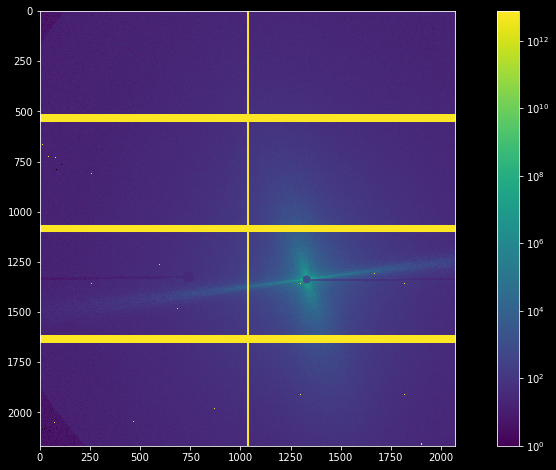

In [10]:
plt.figure()
plt.imshow( SumImages, norm=LogNorm() )
plt.colorbar()
plt.show()

In [11]:
my_images.shape

(1800, 2167, 2070)

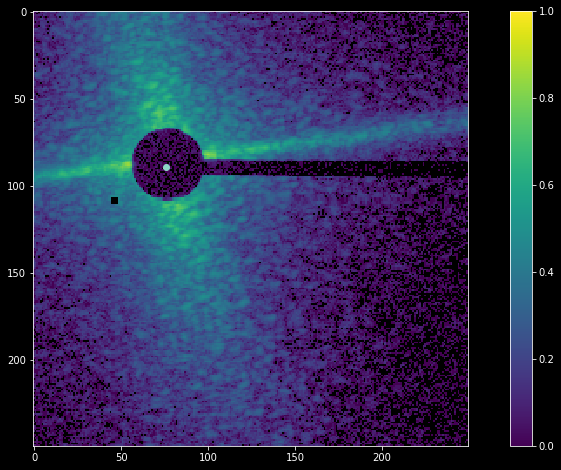

In [25]:
dart = my_images[0,1250:1500,1250:1500]
Xc = 76
Yc = 89
dart[dart>10**7] = 0
Center = (1250+Yc,1250+Xc)
plt.imshow( dart , norm=LogNorm())
plt.scatter( Xc, Yc )
plt.colorbar()

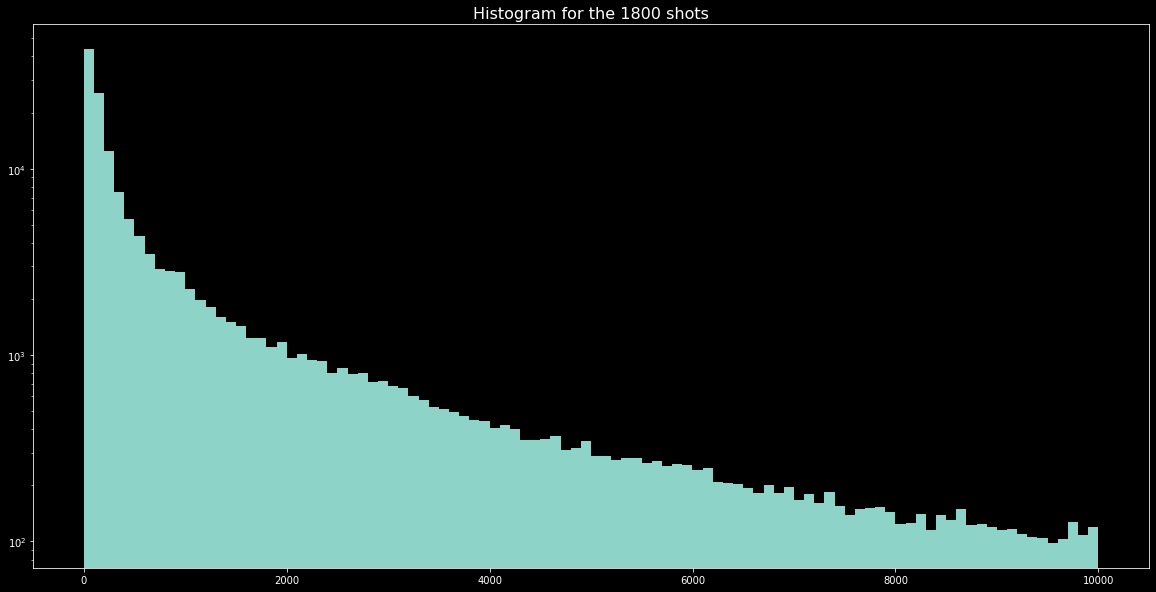

In [16]:
arav = a.ravel()
plt.figure()
plt.title( 'Histogram for the {} shots'.format( str(my_images.shape[0]) ), fontsize=16 )
plt.hist(arav[arav<10**4], bins=100)
plt.yscale('log')
plt.show()
del a

In [5]:
Xc = 76
Yc = 89
Center = (1250+Yc,1250+Xc)
center = np.asarray(Center)
TL = center - 250
RB = center + 250
ROI = [np.arange(TL[0],RB[0]), np.arange(TL[1],RB[1]) ]   

In [6]:
ROI = np.asarray(ROI)
ROI.shape

(2, 500)

In [7]:
threshold = 2
Speckles = my_images[:,TL[0]:RB[0],TL[1]:RB[1] ]
Speckles[Speckles>10**7] = 0
Speckles[Speckles<threshold] = 0 
del my_images
Speckles.shape

(1800, 500, 500)

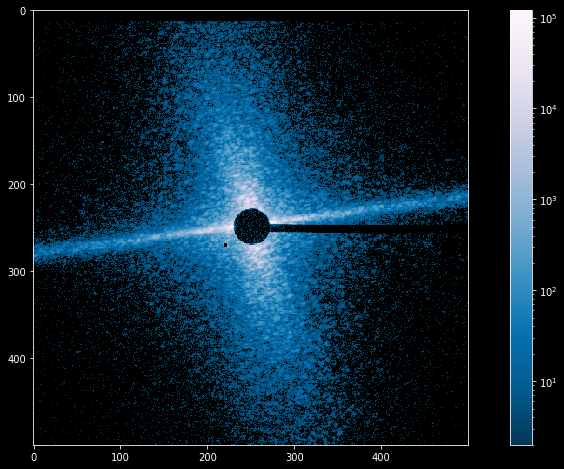

In [10]:
Speck = Speckles[10]
#plt.imshow( Speck, norm=LogNorm(vmin=Speck.min()+10**-5, vmax=Speck.max()), cmap='PuBu_r') 
plt.imshow( Speck, norm=LogNorm(), cmap='PuBu_r') 
plt.colorbar()

where to find the LogNorm for imshow: 
https://www.google.com/search?client=safari&rls=en&q=plt+imshow+log&ie=UTF-8&oe=UTF-8

and where to find animated imshow plots:
https://stackoverflow.com/questions/6686550/how-to-animate-a-time-ordered-sequence-of-matplotlib-plots

animated plots 3D:
https://geoffboeing.com/2015/04/animated-3d-plots-python/



In [8]:
def browse_images(ax, res, im=None):
    N = len(res)
    if im is None:
        im = ax.imshow(res[0], cmap='viridis', interpolation='nearest')
    def view_image(i=0):
        im.set_data(res[i])
        ax.set_title('Image {0}'.format(i))
        fig.canvas.draw_idle()

## Define an angular ROI to avoid truncation rod and beamstop

In [39]:
def polarCoord(img_size, center):
    x, y = np.arange(img_size[1]), np.arange(img_size[0])
    xx, yy = np.meshgrid(x,y)
    cx = center[0]
    cy = center[1]
    
    rad = np.sqrt((xx-cx)**2+(yy-cy)**2)
    phi = np.rad2deg(-np.arctan2(yy-cy,xx-cx))
    return rad, phi

def polarROI(rad, phi, ra, rb, phia, phib):
    """ Polar ROI
    
    Args:
        rad, phi: output of polarCoord
        ra, rb: radial range
        phia, phib: azimuthal range
    """
    if phib<0 and phib<phia:
        ROI = np.logical_and((ra<=rad)*(rad<=rb), (phia<=phi)*(phi<=180))
        ROI = ROI + np.logical_and((ra<=rad)*(rad<=rb), (phi<=phib))
    else:
        ROI = np.logical_and((ra<=rad)*(rad<=rb), (phia<=phi)*(phi<=phib))
    return ROI

def roi_lsco(eiger_img, com, r0, dr, phi0, dphi, tilt):
    rad, phi = polarCoord(eiger_img.shape, com)
    ra = r0-dr
    rb = r0+dr
    phi0 = phi0 + tilt
    phia = phi0-dphi
    phib = phi0+dphi
    if phib>180:
        phib = phib-360
    roi = polarROI(rad, phi, ra, rb, phia, phib)
    return roi

In [99]:
labeled_roi_array_tilt1 = roi_lsco(Speckles[0], (200,200), 150, 5, 90, 25, 8)
labeled_roi_array_tilt2 = roi_lsco(Speckles[0], (200,200), 150, 5, 90, 25, 8-180)
labeled_roi_array_tilt = labeled_roi_array_tilt1 + labeled_roi_array_tilt2

## Define the ROI

In [49]:
# define the ROIs
roi_start = 40 # in pixels
roi_width = 2 # in pixels
roi_spacing = (0)
x_center = 100. # in pixels
y_center = (100.) # in pixels
num_rings = 1

# get the edges of the rings
edges = roi.ring_edges(roi_start, width=roi_width, 
                       spacing=roi_spacing, num_rings=num_rings)

# get the label array from the ring shaped 3 region of interests(ROI's)
labeled_roi_array = roi.rings(
    edges, (y_center, x_center), Speckles.shape[1:]) 

## Plot the ROI

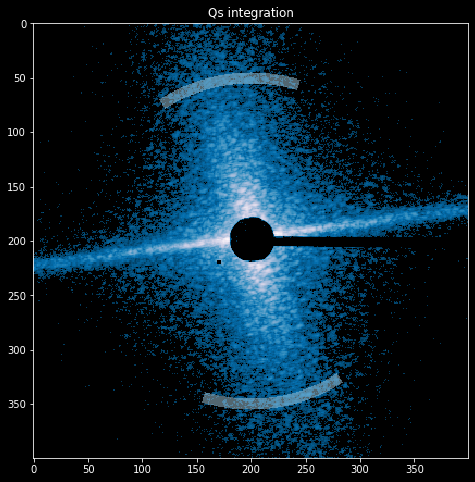

In [100]:
def overlay_rois(ax, image, label_array):
    """
    This will plot the reqiured roi's on the image
    """
    tmp = np.array(label_array, dtype='float')
    tmp[label_array==0] = np.nan
    
    im_data = ax.imshow(image, interpolation='none', norm=LogNorm(), cmap='PuBu_r')
    im_overlay = ax.imshow(tmp, cmap='Paired', 
                   interpolation='nearest', alpha=.5,)
    
    return im_data, im_overlay

fig, ax = plt.subplots()
plt.title('Qs integration')
im_data, im_overlay = overlay_rois(ax, Speckles[0], labeled_roi_array_tilt)
plt.show()

In [33]:
tic = time.time()

# it would be great to have a link to what this multi-tau scheme is!
num_levels = 7
num_bufs = 8

# multi_tau_auto_corr(num_levels, num_bufs, labels, images)¶

#lazy_one_time(image_iterable, num_levels, num_bufs, labels, internal_state=None)¶
# g2 one time correlation results for 3 ROI's
#g2, lag_steps = corr.lazy_one_time( Speckles, num_levels, num_bufs, labeled_roi_array)
# lag_staps are delays for multiple tau analysis
g2, lag_steps = corr.multi_tau_auto_corr(
    num_levels, num_bufs, labeled_roi_array, (im for im in Speckles))
lag_time = 1
lag_step = lag_steps[:g2.shape[0]]
lags = lag_step*lag_time

toc = time.time(); print(toc - tic)

11.569600820541382


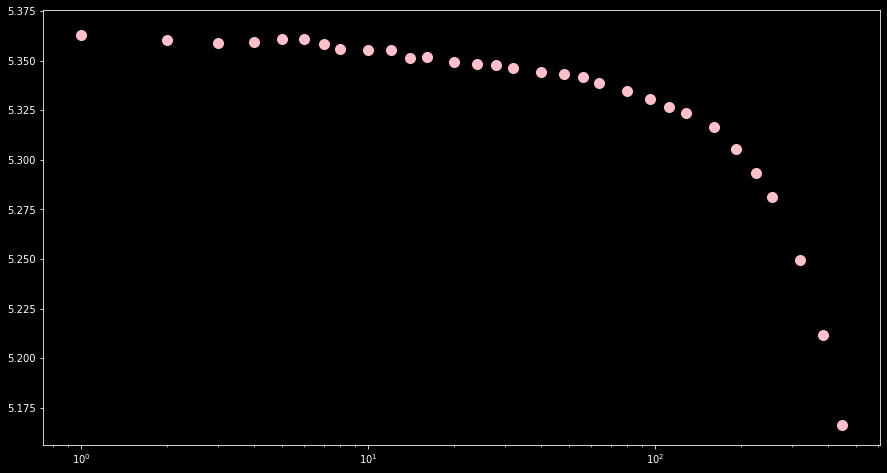

In [43]:
if num_rings > 1:
    fig, axes = plt.subplots(num_rings, sharex=True, figsize=(10,7))
    axes[-1].set_xlabel("lags [s]")

    for ax, roi_color, _g2 in zip(axes, cm.get_cmap('Paired')(np.linspace(0, 1, 3)), g2.T):
        ax.set_ylabel("g2") 
        ax.semilogx(lags, _g2, 'o', markerfacecolor=roi_color, markersize=10, markeredgecolor=roi_color)
        
else:
    plt.semilogx(lags, g2, 'o', markerfacecolor='pink', markersize=10, markeredgecolor='pink')
    

5.019458770751953


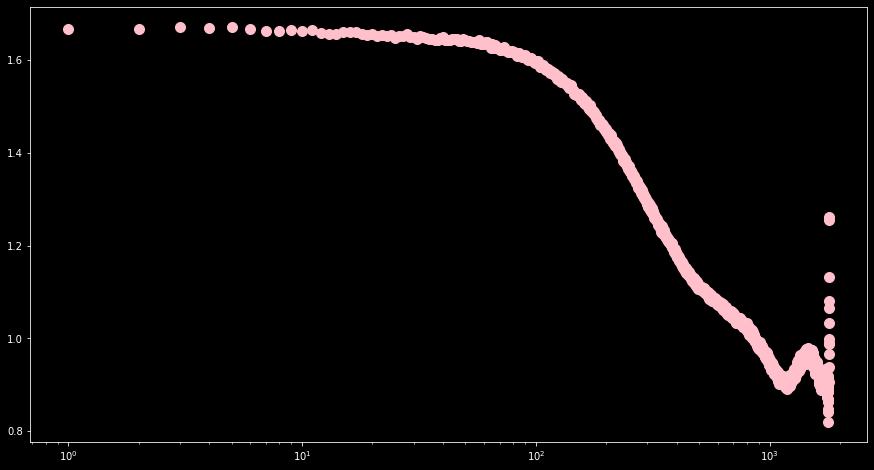

In [194]:
# Performs a one time correlation on Q values (or slected pixel)
tic = time.time()
QpointY = np.arange(150,200,1); QpointX = np.arange(175,225,1)
QpointsY, QpointsX = np.asarray( np.where( labeled_roi_array_tilt == 1 ) )

Qcorr_av = np.zeros(Speckles.shape[0]-1)
tau = 1
ind = 10
# Loop over all the pairs of tau = 1,2,...N
for uu in range(Speckles.shape[0]-1):
    
    NumQcorr =  np.mean( Speckles[0:-1-tau:1, QpointsY[:ind], QpointsX[:ind]]*Speckles[tau:-1:1,QpointsY[:ind],QpointsX[:ind]] )
    DenomQcorr =  np.mean(Speckles[0:-1-tau:1, QpointsY[:ind],QpointsX[:ind]])*np.mean( Speckles[tau:-1:1,QpointsY[:ind],QpointsX[:ind]] )
    Qcorr_av[uu] = NumQcorr/DenomQcorr
    tau+=1

plt.semilogx( Qcorr_av, 'o', markerfacecolor='pink', markersize=10, markeredgecolor='pink')
toc = time.time(); print(toc - tic)


## Brute force one time correlation 

In [50]:
tic = time.time()

# it would be great to have a link to what this multi-tau scheme is!
num_levels = 1
num_bufs = 1800

# multi_tau_auto_corr(num_levels, num_bufs, labels, images)¶

#lazy_one_time(image_iterable, num_levels, num_bufs, labels, internal_state=None)¶
# g2 one time correlation results for 3 ROI's
#g2, lag_steps = corr.lazy_one_time( Speckles, num_levels, num_bufs, labeled_roi_array)
# lag_staps are delays for multiple tau analysis

g2, lag_steps = corr.multi_tau_auto_corr(
    num_levels, num_bufs, labeled_roi_array, (im for im in Speckles))
lag_time = 1
lag_step = lag_steps[:g2.shape[0]]
lags = lag_step*lag_time

toc = time.time(); print(toc - tic)

868.9085838794708


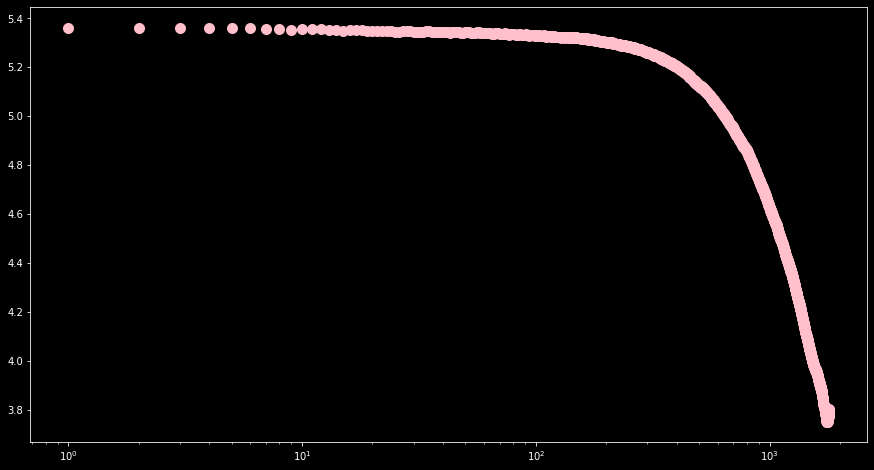

In [51]:
if num_rings > 1:
    fig, axes = plt.subplots(num_rings, sharex=True, figsize=(10,7))
    axes[-1].set_xlabel("lags [s]")

    for ax, roi_color, _g2 in zip(axes, cm.get_cmap('Paired')(np.linspace(0, 1, 3)), g2.T):
        ax.set_ylabel("g2") 
        ax.semilogx(lags, _g2, 'o', markerfacecolor=roi_color, markersize=10, markeredgecolor=roi_color)
        
else:
    plt.semilogx(lags, g2, 'o', markerfacecolor='pink', markersize=10, markeredgecolor='pink')

## Two time correlation function 

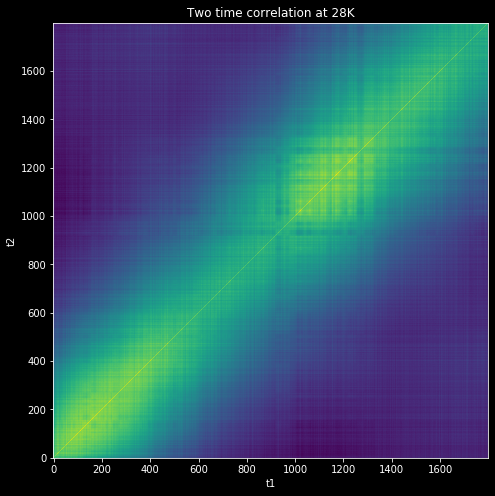

721.8928439617157


In [101]:
# run the correlation on the full stack
tic = time.time()
full_gen = corr.lazy_two_time(labeled_roi_array_tilt, Speckles, Speckles.shape[0],
                             num_bufs=Speckles.shape[0], num_levels=1)
for full_state in full_gen:
        pass
    
final_result = corr.two_time_state_to_results(full_state)

fig, ax = plt.subplots()
plt.imshow(final_result.g2[0], origin="lower")
plt.xlabel("t1")
plt.ylabel("t2")
plt.title("Two time correlation at 28K")
plt.show()
toc = time.time()
print( toc-tic )

In [29]:
mod = Model(corr.auto_corr_scat_factor)

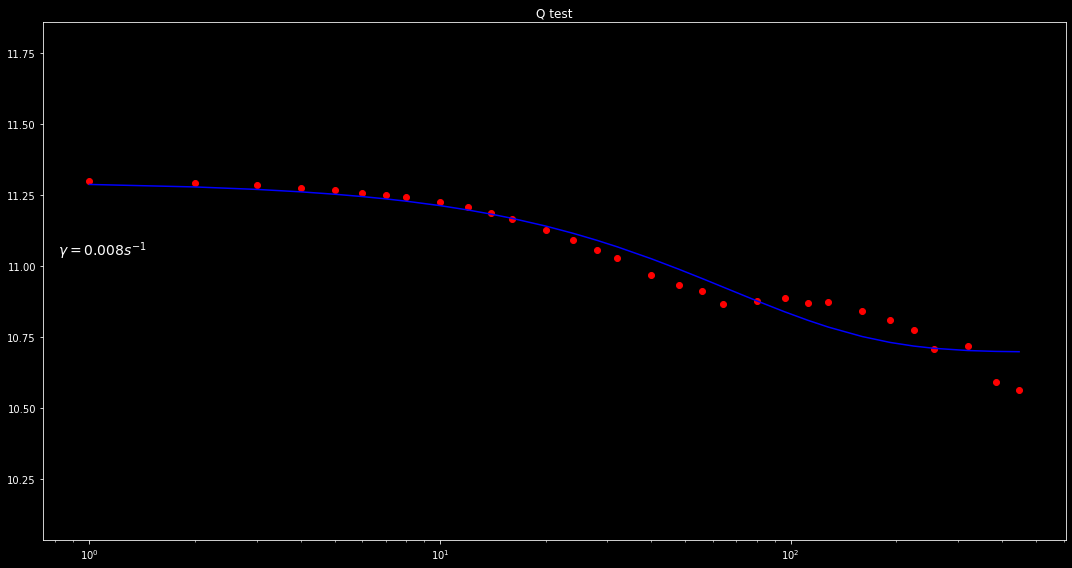

In [47]:
rate = []  #  relaxation rate

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
fig = plt.figure()
plt.title('LSBC data 005', fontsize=20, y =1.02) 
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    y=g2[1:, i]
    result1 = mod.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =0.01, baseline=1.0)
    rate.append(result1.best_values['relaxation_rate'])
    
    ax.semilogx(lags[1:], y, 'ro')
    ax.semilogx(lags[1:], result1.best_fit, '-b')
    ax.set_title("Q test")  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.3f$'%(rate[i]) +  r'$ s^{-1}$'
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes)              
fig.tight_layout()  
plt.show()

In [204]:
def exponential(x, a, k, b):
    return a*np.exp(x*k) + b

In [205]:
xdata = range(1798)

In [69]:
Qcorr_av = np.asarray(Qcorr_av)
Qcorr_av = Qcorr_av[~np.isnan(Qcorr_av)]
popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, xdata, Qcorr_av, p0=[1,-0.5, 1])

Text(0.05, 0.55, '$\\gamma$$ = -0.001$$ s^{-1}$')

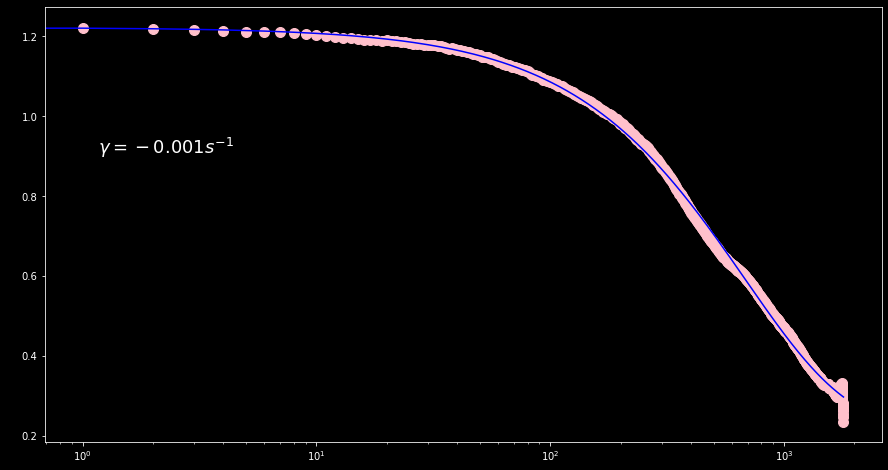

In [82]:
perr_linear = np.sqrt(np.diag(pcov_exponential))
plt.semilogx( Qcorr_av, 'o', markerfacecolor='pink', markersize=10, markeredgecolor='pink')
plt.semilogx( exponential(xdata, popt_exponential[0], popt_exponential[1], popt_exponential[2]), 'b' )
txts = r'$\gamma$' + r'$ = %.3f$'%(popt_exponential[1]) +  r'$ s^{-1}$'
plt.text(x =0.05, y=.55, s=txts, fontsize=18, transform=ax.transAxes)   

## Two time correlation as function of Q roi's

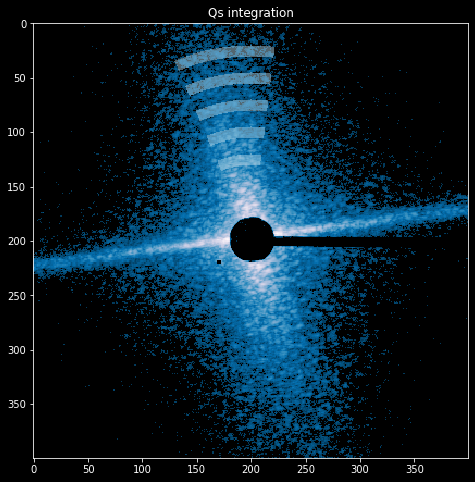

In [21]:
Qs = [75, 100, 125, 150 ,175]
Angulars = [15, 15, 15, 15, 15]
labeled_roi_array_tilts = np.zeros( (5, Speckles.shape[1], Speckles.shape[2]) )
qq = 0

for Q, Ang in zip(Qs, Angulars):
    labeled_roi_array_tilts[qq] = roi_lsco(Speckles[0], (200,200), Q, 5, 90, Ang, 8)
    qq +=1 
    

fig, ax = plt.subplots()
plt.title('Qs integration')
im_data, im_overlay = overlay_rois(ax, Speckles[0], labeled_roi_array_tilts.sum(axis=0) )
plt.show()

## One time normalised correlation as function of Q

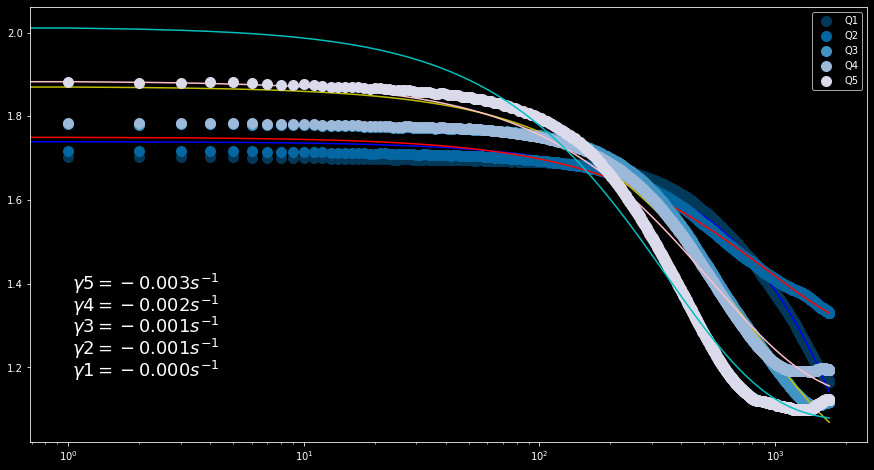

In [259]:
# Fitting a simple exponential 

fig, ax = plt.subplots()
colors = ['b','r','y', 'pink', 'c']
labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
cmap = plt.get_cmap('PuBu_r')

for yy, label, col in zip(range(5), labels, colors):
    
    xdata = np.arange(len(Qcorr_ave[:-100]))
    Qcorr_ave = Qcorr_avs[yy]
    Qcorr_ave = Qcorr_ave[~np.isnan(Qcorr_ave)]
    popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, xdata, Qcorr_ave[:-100], 
                                                                  p0=[1,-0.05, 1])

    perr_linear = np.sqrt(np.diag(pcov_exponential))
    color = cmap(float(yy)/5)
    plt.semilogx( Qcorr_ave[:-100], 'o', markerfacecolor=color, markersize=10, markeredgecolor=color,
                label=label)
    plt.legend()
    plt.semilogx( exponential(xdata, popt_exponential[0], popt_exponential[1], popt_exponential[2]), col )
    txts = r'$\gamma$'+str(yy+1) + r'$ = %.3f$'%(popt_exponential[1]) +  r'$ s^{-1}$'
    plt.text(x =0.05, y=.15+(yy/20), s=txts, fontsize=18, transform=ax.transAxes)   

plt.show() 

## Departing from simple exponential

/Users/roibabar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/roibabar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


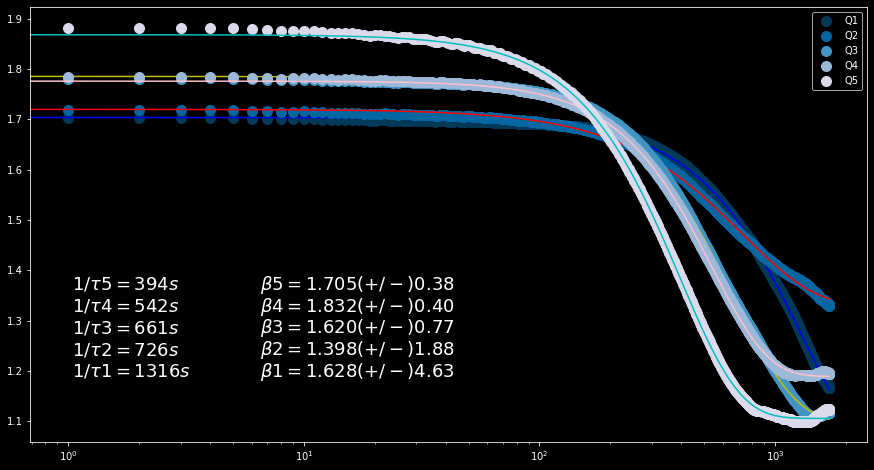

In [298]:
xpcs.PlotBetaExponential(Qcorr_avs)

## Looking at the symmetric ROI

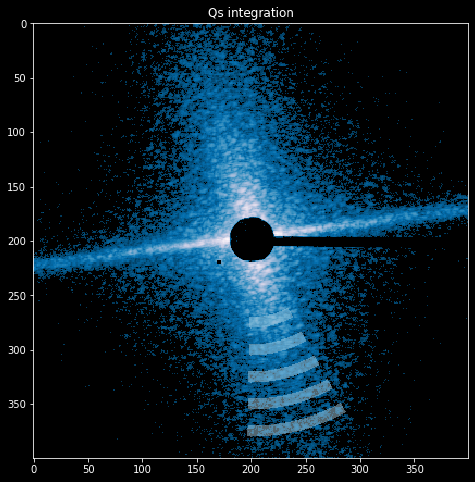

In [30]:
Qs = [75, 100, 125, 150 ,175]
Angulars = [15, 15, 15, 15, 15]
labeled_roi_array_tilts = np.zeros( (5, Speckles.shape[1], Speckles.shape[2]) )
qq = 0

for Q, Ang in zip(Qs, Angulars):
    labeled_roi_array_tilts[qq] = roi_lsco(Speckles[0], (200,200), Q, 5, -82, Ang, 6)
    qq +=1 
    

fig, ax = plt.subplots()
plt.title('Qs integration')
im_data, im_overlay = overlay_rois(ax, Speckles[0], labeled_roi_array_tilts.sum(axis=0) )
plt.show()

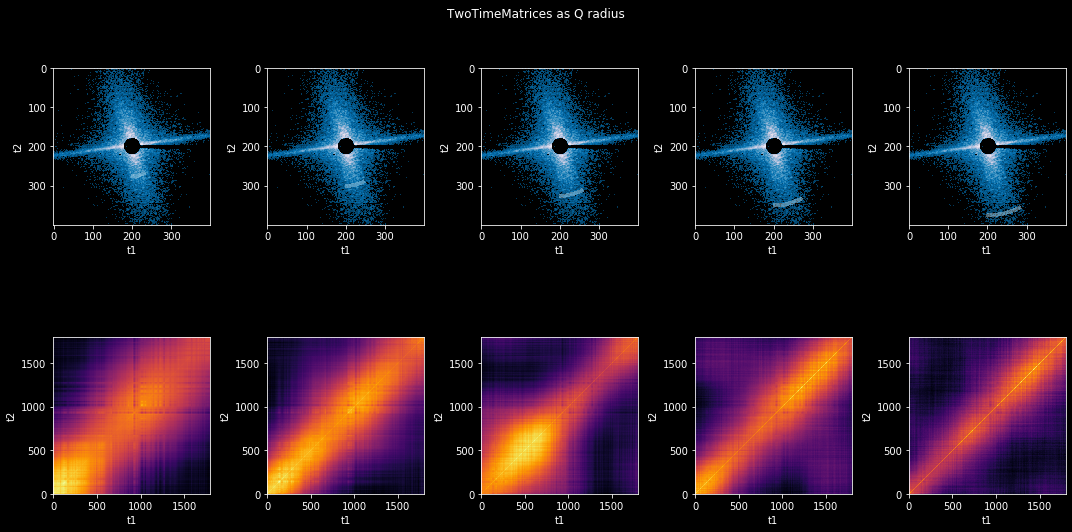

In [40]:
xpcs.TwoTimeCorrelationROIs(labeled_roi_array_tilts)

In [33]:
Qcorr_avs = OneTimeCorrelationNormROIs(labeled_roi_array_tilts)

/Users/roibabar/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/roibabar/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1035.2686829566956


/Users/roibabar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


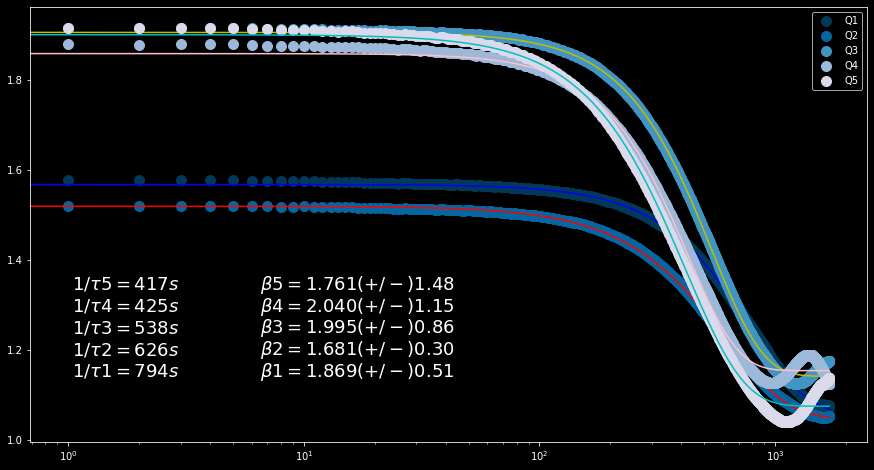

In [45]:
PlotBetaExponential(Qcorr_avs)

## Looking at more constant ROIs

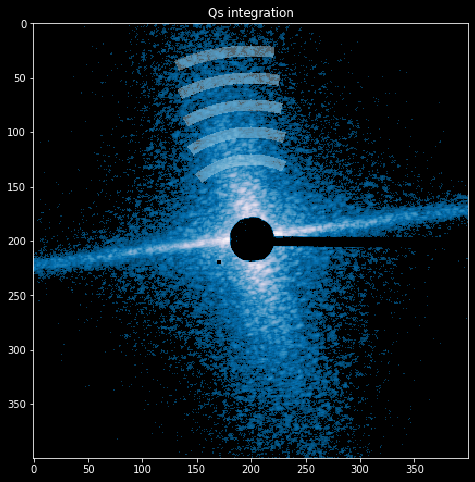

In [57]:
Qs = [75, 100, 125, 150 ,175]
Angulars = [32, 26, 21, 18, 15]
labeled_roi_array_tilts = np.zeros( (5, Speckles.shape[1], Speckles.shape[2]) )
qq = 0

for Q, Ang in zip(Qs, Angulars):
    labeled_roi_array_tilts[qq] = roi_lsco(Speckles[0], (200,200), Q, 5, 90, Ang, 8)
    qq +=1 
    

fig, ax = plt.subplots()
plt.title('Qs integration')
im_data, im_overlay = overlay_rois(ax, Speckles[0], labeled_roi_array_tilts.sum(axis=0) )
plt.show()

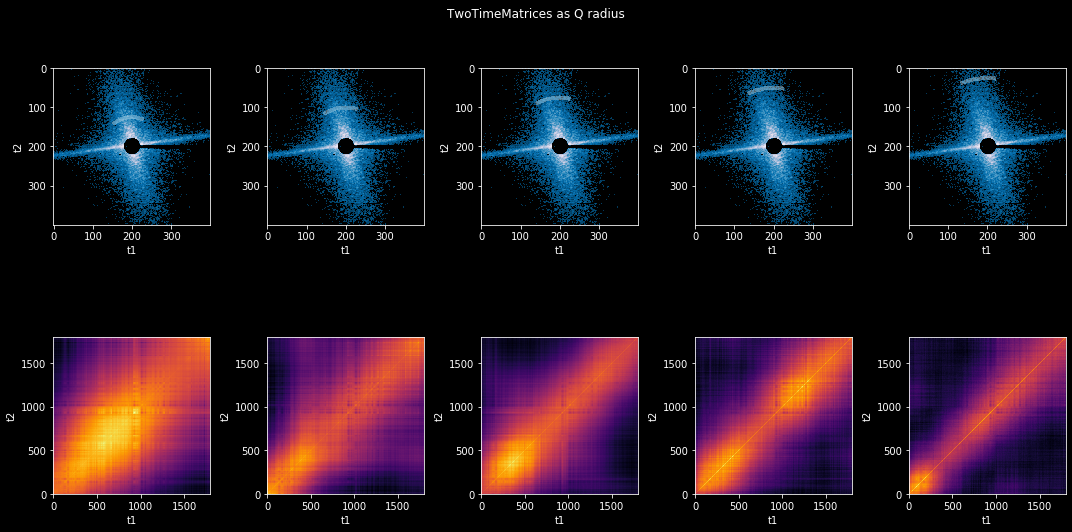

1563.234202861786


In [60]:
TwoTimeCorrelationROIs(labeled_roi_array_tilts)

6673.262824058533


/Users/roibabar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/roibabar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


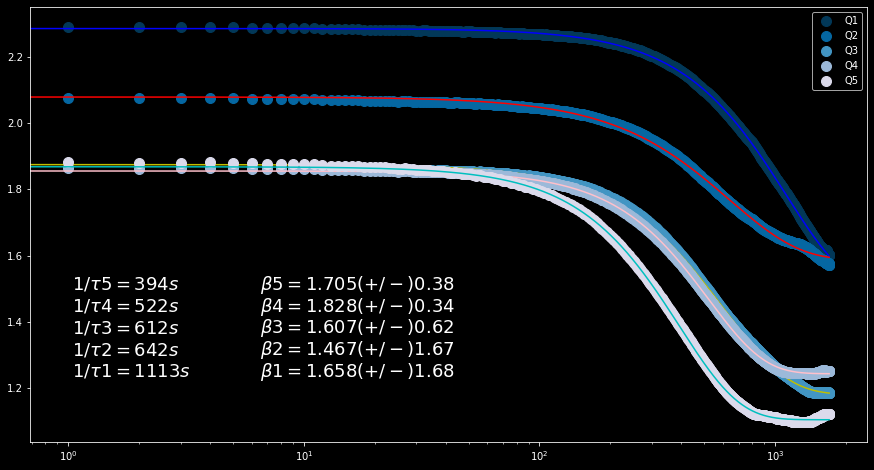

In [65]:
Qcorr_avs = OneTimeCorrelationNormROIs(labeled_roi_array_tilts)
PlotBetaExponential(Qcorr_avs)

## Looking for oscillations f(angular steps) 

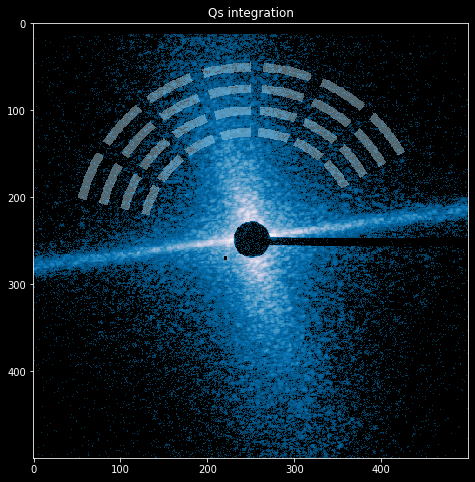

In [178]:
Qs = [125, 150, 175, 200]
Azimuths = [30, 50, 70, 90, 110, 130, 150 ]
labeled_roi_array_tilts = np.zeros( (len(Qs)*len(Azimuths), Speckles.shape[1], Speckles.shape[2]) )
qq = 0

for Q in Qs:
    for Azimuth in Azimuths:
        labeled_roi_array_tilts[qq] = roi_lsco(Speckles[0], (250,250), Q, 5, Azimuth, 8, 8)
        qq +=1 
    

fig, ax = plt.subplots()
plt.title('Qs integration')
im_data, im_overlay = xpcs.overlay_rois(ax, Speckles[0], labeled_roi_array_tilts.sum(axis=0) )
plt.show()

In [96]:
def Gamma_exponential(x, a, tau, beta, b):
    return a*np.exp(-(x/tau)**beta) + b


## Correcting for the illumination non-uniformity

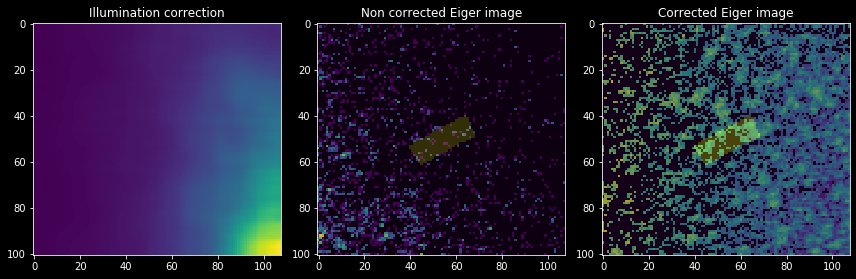

In [175]:
ksize = 20
if ksize is None:
    extend = 10
else:
    extend=2*ksize
    
ROImask = labeled_roi_array_tilts[4] > 0
Speckles_corr, roi, bp = xpcs.correct_illumination(Speckles, ROImask, kernel_size=ksize)

fig, ax = plt.subplots(ncols=3, figsize=(12,12))
ax[0].set_title('Illumination correction')
ax[0].imshow(bp)

ax[1].set_title('Non corrected Eiger image')
ax[1].imshow(xpcs.box_to_roi_extend(Speckles[1000],labeled_roi_array_tilts[1], extend=extend)[0], norm=LogNorm())
ax[1].imshow(roi, alpha=0.2)

ax[2].set_title('Corrected Eiger image')
ax[2].imshow(Speckles_corr[1000], norm=LogNorm())
ax[2].imshow(roi, alpha=0.3)

plt.tight_layout()
plt.show()

In [167]:
Qcorr_avs_corr = xpcs.OneTimeCorrelationNorm_ROIsCorrected(labeled_roi_array_tilts, Speckles)

408.2739689350128


In [188]:
Qcorr_avs_corr = xpcs.OneTimeCorrelationNorm_ROIsCorrected(labeled_roi_array_tilts, Speckles)

3762.0450880527496


In [391]:
Qcorr_avs_noncorr = xpcs.OneTimeCorrelationNormROIs(labeled_roi_array_tilts, Speckles)

/Users/roibabar/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/roibabar/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3807.8292710781097


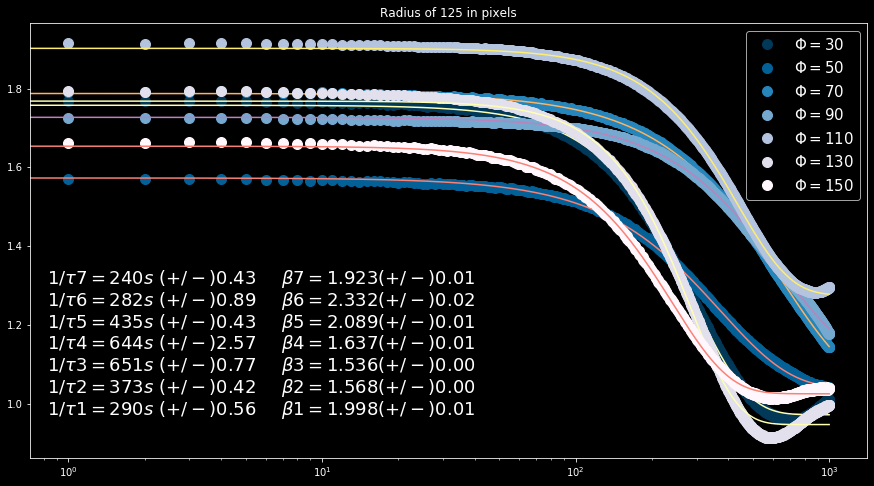

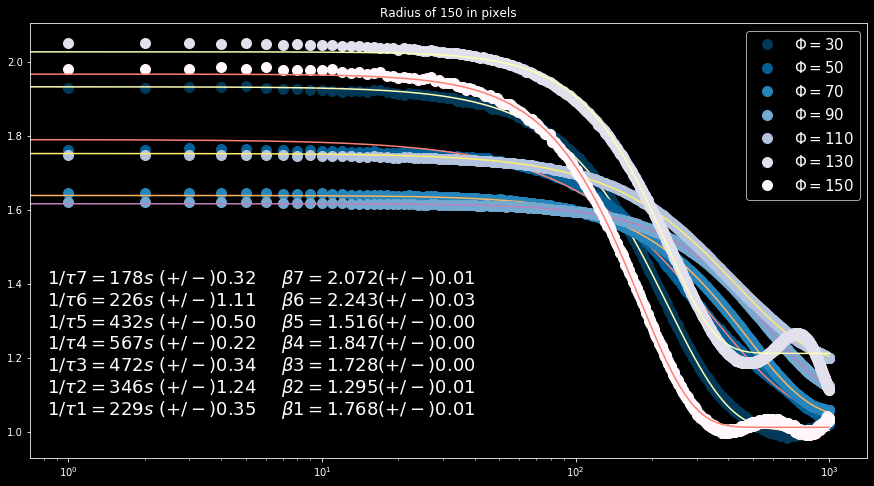

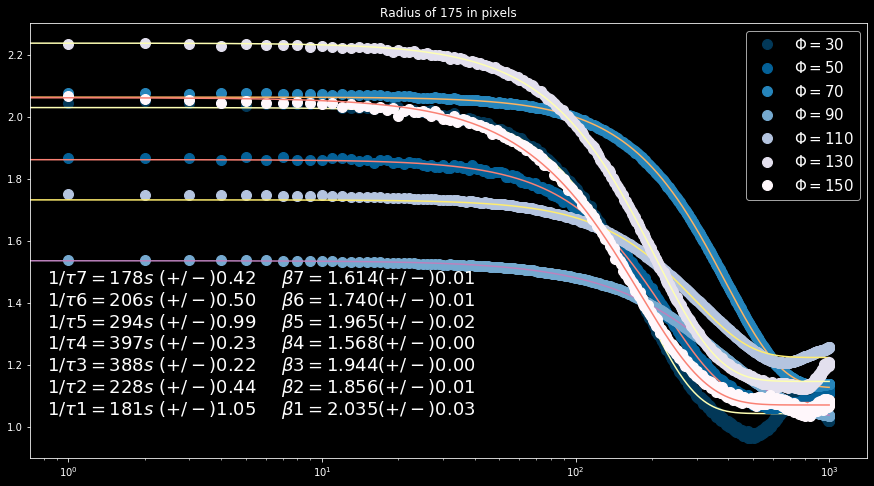

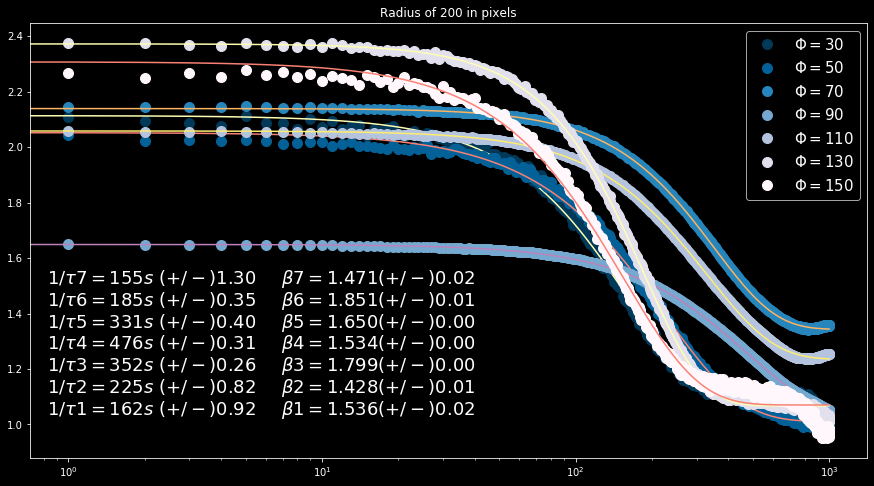

In [392]:
perr_linears = []; pcov_exponentials = []; popt_exponentials = []
Radius = [125, 150, 175, 200]
Azimuths = [30, 50, 70, 90, 110, 130, 150 ]
endex=800
Parameters = []
qq = 0

for Rad in Radius:
    
    yy = 0
    fig, ax = plt.subplots()
    ax.set_title('Radius of {0:d} in pixels'.format(Rad))
    cmap = plt.get_cmap('PuBu_r')
    cmap2 = plt.get_cmap('jet')
    
    for Azimuth in Azimuths:

        Qcorr_ave = Qcorr_avs_noncorr[qq]
        popt_exponential, pcov_exponential, perr_linear  = xpcs.FitFunction(Qcorr_avs_noncorr[qq], 
                                                                       func=Gamma_exponential, 
                                                                       endex=endex, 
                                                                       p0=[1,300, 1.5, 1])

        popt_exponentials.append(popt_exponential); pcov_exponentials.append(pcov_exponential); perr_linears.append(perr_linear)
        color = cmap(float(yy)/Qcorr_avs.shape[0])
        color2 = cmap2(float(yy)/Qcorr_avs.shape[0])
        plt.semilogx( Qcorr_ave[:-endex], 'o', markerfacecolor=color, markersize=10, markeredgecolor=color,
                    label= '$\Phi=$' + str(Azimuth))
        plt.legend(fontsize=15)
        plt.semilogx( Gamma_exponential( np.arange(len(Qcorr_ave[:-endex])), 
                                        popt_exponential[0], 
                                        popt_exponential[1], 
                                        popt_exponential[2], 
                                        popt_exponential[3])  )
        txts = ( r'$\beta$'+ str(yy+1) + r'$ = %.3f$'%( popt_exponential[2] ) + 
                  r'$ (+/-) %.2f$'%( perr_linear[2] )   ) 
        plt.text(x =0.3, y=.1+(yy/20), s=txts, fontsize=18, transform=ax.transAxes) 
        txts = (r'$1/ \tau$'+str(yy+1) + r'$ = %.0f$'%( popt_exponential[1] )  + r'$ s$ ' +
                 r'$ (+/-) %.2f$'%( perr_linear[1] )   ) 
        plt.text(x =0.02, y=.1+(yy/20), s=txts, fontsize=18, transform=ax.transAxes) 
        qq+=1; yy+=1
        
        
    plt.show() 
    
Params_noncorr = { 'popt_exponentials' : np.asarray(popt_exponentials),
          'pcov_exponentials' : np.asarray(pcov_exponentials),
          'perr_linears' : np.asarray(perr_linears) }
          
          
save_path = Path('/Users/roibabar/Documents/Desy-P10-data/Preliminary-results')
fname = 'res'+str(numor)+'_fitsParameters'+'.h5'
save_path = str(save_path / fname)

with h5.File(save_path, 'w') as f:
    f.create_dataset('popt_exponentials', data=popt_exponentials)
    f.create_dataset( 'pcov_exponentials' , data=pcov_exponentials)
    f.create_dataset('perr_linears', data=perr_linears)


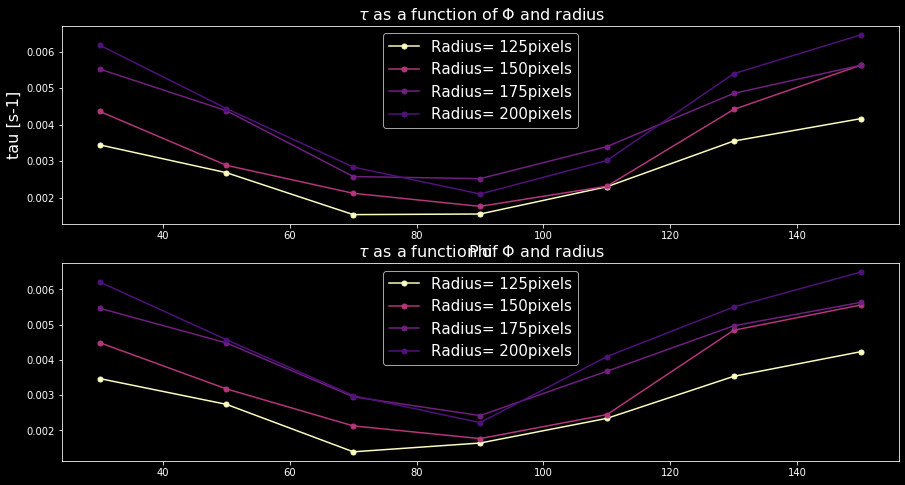

In [407]:
Radius = [125, 150, 175, 200]
Azimuths = [30, 50, 70, 90, 110, 130, 150 ]
inc = 0; ii = 0
fig, ax = plt.subplots(nrows=2)
cmap = plt.cm.get_cmap('magma')

for Rad in Radius:
    ax[0].plot(Azimuths, 1/Params_noncorr['popt_exponentials'][inc:inc+7,1], '-o', markersize=5, 
             label='Radius= ' + str(Rad) + 'pixels',
             color=cmap(255//(ii+1)))
    ax[1].plot(Azimuths, 1/Params_corr['popt_exponentials'][inc:inc+7,1], '-o', markersize=5, 
             label='Radius= ' + str(Rad) + 'pixels',
              color=cmap(255//(ii+1)))
    inc+=7; ii+=1

ax[0].set_ylabel('tau [s-1]', fontsize=16)
ax[0].set_xlabel('Phi', fontsize=16)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[0].set_title(' $\\tau$ as a function of $\\Phi$ and radius ' , fontsize=16)
ax[1].set_title(' $\\tau$ as a function of $\\Phi$ and radius ' , fontsize=16)
plt.show()


where to find color matplotlib maps: 

https://www.google.com/search?q=matplotlib+lava+map&tbm=isch&ved=2ahUKEwi3goWi2bzqAhWGATQIHdVWDa0Q2-cCegQIABAA&oq=matplotlib+lava+map&gs_lcp=CgNpbWcQA1D4F1jHHWC7ImgAcAB4AIABX4gB2AKSAQE0mAEAoAEBqgELZ3dzLXdpei1pbWc&sclient=img&ei=TzsFX_eeHIaD0PEP1a216Ao&bih=743&biw=1414&client=safari

In [310]:
Speckles_corr, roi, bp = xpcs.correct_illumination(Speckles, labeled_roi_array_tilts[-1] > 0, kernel_size=ksize)

full_gen = corr.lazy_two_time( np.asarray(roi).astype('int64'), Speckles_corr, 
                              Speckles_corr.shape[0],
                              num_bufs=Speckles_corr.shape[0], num_levels=1) 

for full_state in full_gen:
    pass

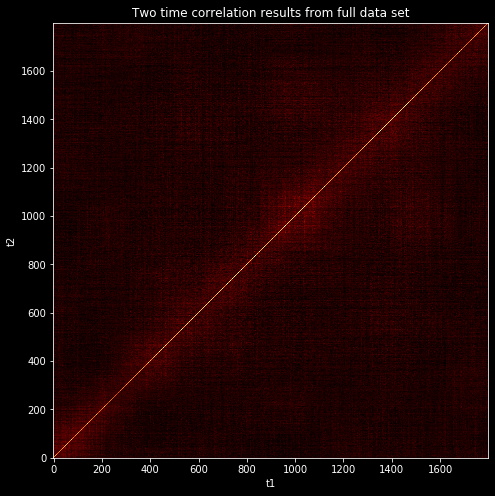

In [311]:
final_result = corr.two_time_state_to_results(full_state)

plt.imshow(final_result.g2[0], origin="lower", cmap='afmhot')
plt.xlabel("t1")
plt.ylabel("t2")
plt.title("Two time correlation results from full data set")
plt.show()

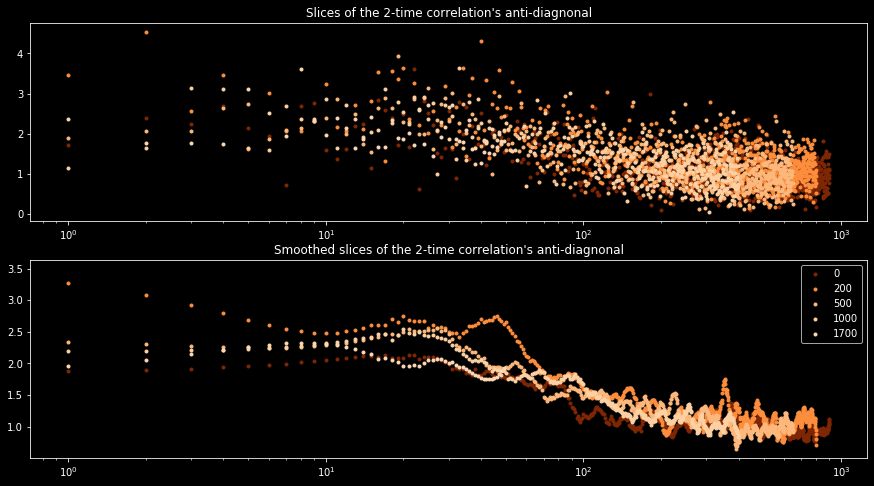

In [327]:
from scipy.signal import savgol_filter

g2 = final_result.g2[0]
one_time_corr_slice = []
g_inv = g2[::-1]

for jj in range(g2.shape[1]):
    one_time_corr_slice.append(np.diag(g_inv, k=jj))
    

fig, ax = plt.subplots(nrows=2)
cmap = plt.cm.get_cmap('Oranges')
Slices = [0, 200, 500, 1000, 1700]
ii = 0

for Slice in Slices:
    trace = one_time_corr_slice[Slice]
    trace = trace[int(trace.shape[0]/2):]
    ax[0].semilogx(trace, 'o', markersize=3, label=Slice, color=cmap(255//(ii+1)))
    ax[1].semilogx(savgol_filter(trace,31,3), 'o', markersize=3, label=Slice, color=cmap(255//(ii+1)))
    ii+=1

ax[1].legend()
ax[0].set_title("Slices of the 2-time correlation's anti-diagnonal")
ax[1].set_title("Smoothed slices of the 2-time correlation's anti-diagnonal")
plt.show()

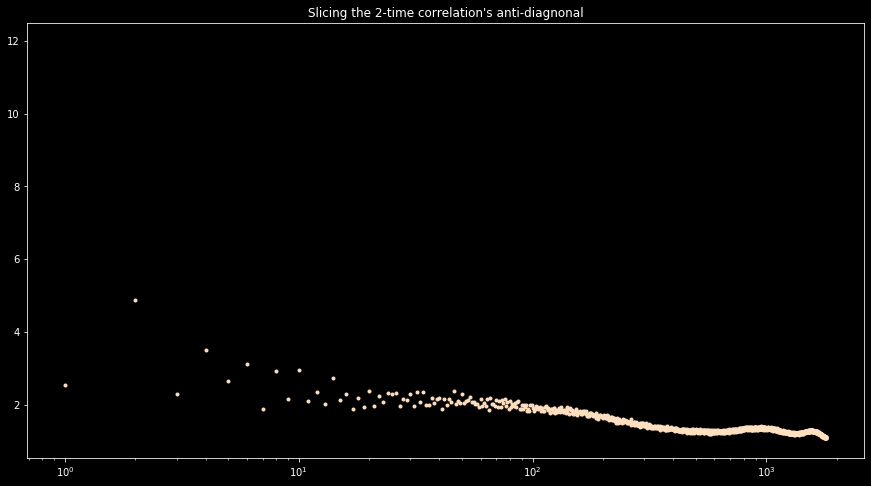

In [320]:
g2 = final_result.g2[0]
one_time_corr_slice = []
g_inv = g2[::-1]

for jj in range(g2.shape[1]):
    one_time_corr_slice.append( np.mean( np.diag(g_inv, k=jj)) )
    

plt.figure()
cmap = plt.cm.get_cmap('Oranges')

plt.semilogx( one_time_corr_slice[::-1], 'o', markersize=3, label='Slice #{}'.format(ii*400), color=cmap(255//(ii+1)))


plt.title("Slicing the 2-time correlation's anti-diagnonal")
plt.show()

In [ ]:
two_time_corr = corr.two_time_corr( np.asarray(labeled_roi_array_tilts[0]).astype('int64'), Speckles, Speckles.shape[0],
                         num_bufs=Speckles.shape[0], num_levels=1 ) 

In [ ]:
one_time_corr = np.zeros((two_time_corr.shape[0], two_time_corr.shape[2]))
for i, g in enumerate(two_time_corr):
    for j in range(g.shape[1]):
        one_time_corr[i, j] = np.nanmean(np.diag(g, k=j)) 